# EDA (TUR-729)

This version will handle cases by loweing them first

- Data from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
- Plenty of records that can be used as indicators of what are being searched.
- Coverage available from August 2019
- Phrases are common - can be broken down into words to get better word clustering
- Cases will need to be handled properly - can get better word clustering as well

Supposedly we can embed these words (subword embedding like or even simple word2vec) and find similarity score with the embedded product metadata (Lindt --> chocolate, balls, etc), then match-make that way?


In [1]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

import pandas as pd
import numpy as np

from google.cloud import bigquery
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = True
bq = bigquery.Client(project='wx-bq-poc')

In [2]:
def get_dataframe(sql):
    df = bq.query(sql).result().to_dataframe()
    return df    

### Number of records

In [3]:
sql = '''
    select 
        count(*) n_records,
        count(distinct lower(udo_search_keyword_5172)) n_keywords
    from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
    where udo_search_keyword_5172 is not null; 
'''
get_dataframe(sql)

n_records  n_keywords
0  947512361    15855569

### Time coverage

In [4]:
sql = '''
    select 
        min(post_time) min_post_time,
        max(post_time) max_post_time
    from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
    where udo_search_keyword_5172 is not null;
'''
get_dataframe(sql)

min_post_time             max_post_time
0 2019-08-16 06:17:38+00:00 2021-05-17 23:59:59+00:00

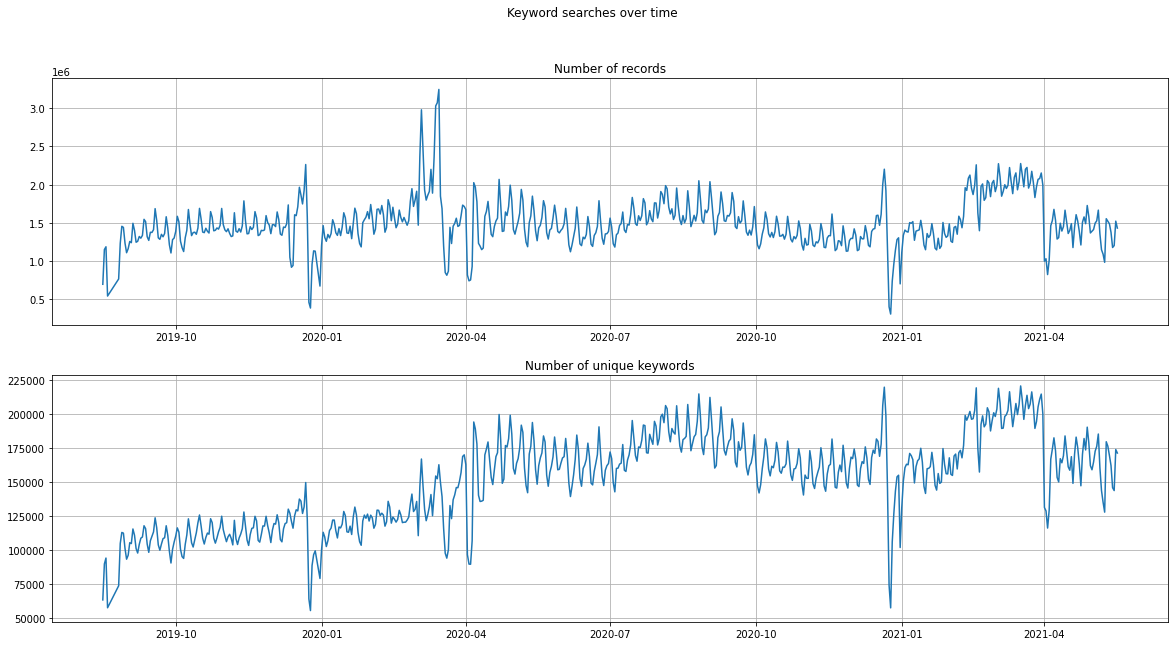

In [5]:
sql = '''
    select 
        date(post_time) as post_date,
        count(*) n_records,
        count (distinct lower(udo_search_keyword_5172)) n_keywords
    from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
    where udo_search_keyword_5172 is not null
    group by 1 order by 1;
'''
df = get_dataframe(sql)

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(df['post_date'], df['n_records'])
ax[0].set_title('Number of records')
ax[1].plot(df['post_date'], df['n_keywords'])
ax[1].set_title('Number of unique keywords')
fig.suptitle('Keyword searches over time')
plt.show()

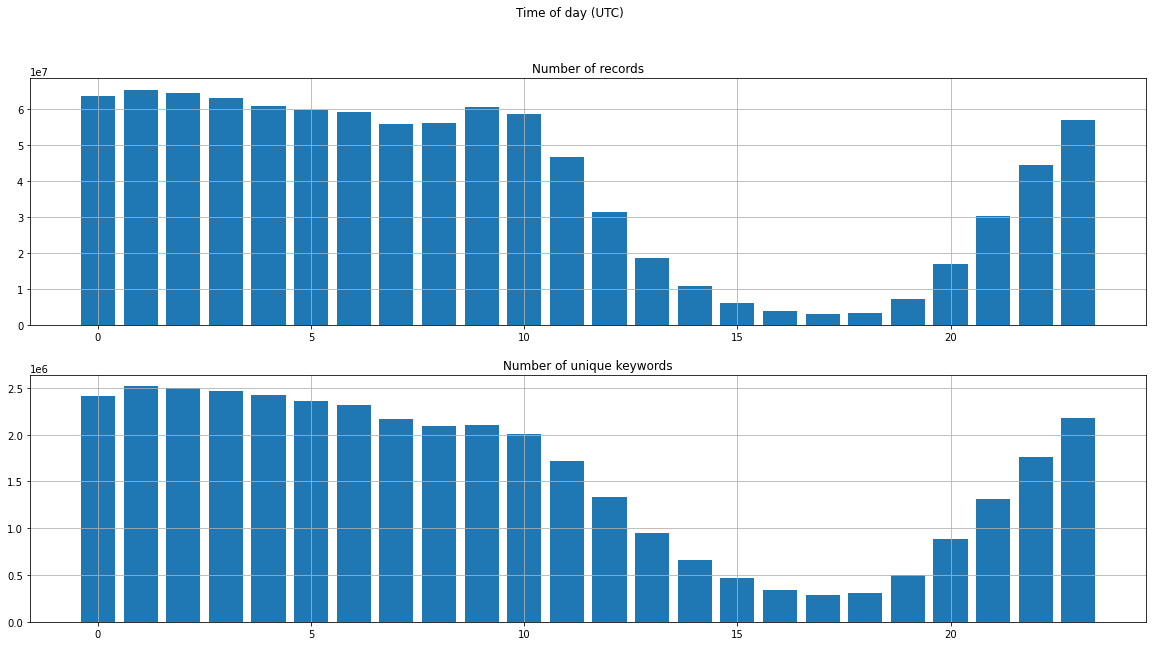

In [6]:
sql = '''
    select 
        extract(hour from post_time) as post_hour,
        count(*) n_records, 
        count (distinct lower(udo_search_keyword_5172)) n_keywords
    from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
    where udo_search_keyword_5172 is not null
    group by 1 order by 1;
'''
df = get_dataframe(sql)

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].bar(df['post_hour'], df['n_records'])
ax[0].set_title('Number of records')
ax[1].bar(df['post_hour'], df['n_keywords'])
ax[1].set_title('Number of unique keywords')
fig.suptitle('Time of day (UTC)')
plt.show()

### Top keyword searches

In [7]:
sql = '''
    select 
        count(*) n_records
    from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
'''
n_records = get_dataframe(sql)['n_records'][0]

sql = '''
    select 
        lower(udo_search_keyword_5172), 
        count(*) n_records
    from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
    where udo_search_keyword_5172 is not null
    group by 1 order by 2 desc
    limit 20;
'''
df = get_dataframe(sql)
df['p_records'] = df['n_records'] / n_records
df

f0_  n_records  p_records
0             milk    8550674   0.000631
1     toilet paper    6561512   0.000484
2            bread    6186889   0.000456
3             eggs    5504927   0.000406
4           cheese    5086640   0.000375
5          chicken    4812390   0.000355
6            chips    4752802   0.000351
7          yoghurt    4567843   0.000337
8        ice cream    4374124   0.000323
9        chocolate    3821070   0.000282
10           pasta    3626112   0.000267
11             ham    3606128   0.000266
12          butter    3545431   0.000262
13           mince    3497949   0.000258
14           bacon    3461621   0.000255
15            rice    3159891   0.000233
16  chicken breast    2908248   0.000215
17           vegan    2831537   0.000209
18         bananas    2702577   0.000199
19           water    2491758   0.000184

In [8]:
sql = '''
    select 
        lower(udo_search_keyword_5172), 
        count(*) n_records
    from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
    where udo_search_keyword_5172 is not null
    group by 1 order by 2
    limit 20;
'''
get_dataframe(sql)

f0_  n_records
0             infused sirloin roast          1
1     woolworths mini icream sticks          1
2     continental soup creamy roast          1
3                   jarred chestnut          1
4                   white starlight          1
5                    sweet pineaple          1
6                   mortein candle           1
7                   motorola moto e          1
8                     chee augustse          1
9             ice and cake decorate          1
10                       75 ethanol          1
11             sparkling bundaberg           1
12             fruit and vegetebles          1
13                     olives latge          1
14             mince fir mince pies          1
15    mco beauty instant campuflage          1
16  woolworths select yoghurt plain          1
17               guinness  stubbies          1
18           bunderberg rum custard          1
19           cupcake patty pansgybv          1

In [9]:
sql = '''
    with foo as (
        select 
            extract(year from post_time) * 100 + extract(month from post_time) as post_month,
            lower(udo_search_keyword_5172) as udo_search_keyword_5172,
            count(*) n_records
        from `wx-bq-poc.wx_lty_digital_attribution_dev.tealium_events`
        where udo_search_keyword_5172 is not null
        group by 1,2
    ), bar as (
        select 
            post_month,
            array_agg(struct(udo_search_keyword_5172, n_records) order by n_records desc limit 20) arr
        from foo 
        group by 1
    )
    select 
        post_month, 
        foobar.*
    from bar, unnest(arr) as foobar
    order by 1, 3 desc
'''
df = get_dataframe(sql)

### Top keyword searches over time

In [10]:
foo = {}
for month in df['post_month'].unique():
    foo[month] = list(df[df['post_month']==month]['udo_search_keyword_5172'])
    
pd.set_option('display.max_columns', 500)
pd.DataFrame(foo)

201908          201909          201910          201911  \
0             milk            milk            milk            milk   
1             eggs           bread           bread           bread   
2            bread            eggs            eggs          cheese   
3          yoghurt         yoghurt          cheese            eggs   
4           cheese          cheese         chicken           mince   
5          chicken         chicken         yoghurt         chicken   
6            chips           chips           chips           chips   
7        chocolate       ice cream       ice cream       ice cream   
8            bacon       chocolate       chocolate         yoghurt   
9        ice cream          butter          butter           vegan   
10          butter           bacon           bacon       chocolate   
11    toilet paper    toilet paper             ham          butter   
12         bananas             ham    toilet paper           bacon   
13             ham         bananas  chicken breast             ham   
14  chicken breast  chicken breast         bananas    toilet paper   
15           pasta         lettuce           vegan         bananas   
16         avocado           pasta         lettuce  chicken breast   
17          tomato        capsicum           pasta         lettuce   
18        potatoes          tomato         avocado           water   
19     gluten free         avocado          tomato         avocado   

          201912          202001          202002          202003  \
0           milk            milk            milk    toilet paper   
1         cheese           bread           bread           pasta   
2          bread            eggs            eggs            rice   
3           eggs           mince           mince  hand sanitiser   
4          chips         chicken          cheese            milk   
5      chocolate          cheese         chicken           mince   
6      ice cream         yoghurt         yoghurt           bread   
7            ham       ice cream           chips          dettol   
8        chicken           chips       ice cream            eggs   
9          mince         lettuce    toilet paper           flour   
10         bacon    toilet paper           bacon         chicken   
11        butter           bacon             ham         tissues   
12         vegan           vegan           pasta          cheese   
13       yoghurt             ham          butter           chips   
14  toilet paper  chicken breast       chocolate          tissue   
15         cream          butter            rice         yoghurt   
16         water           water  chicken breast            tuna   
17       lettuce         bananas         lettuce       chocolate   
18      potatoes       chocolate         bananas   toilet tissue   
19      crackers           pasta          tomato       ice cream   

            202004          202005        202006          202007  \
0     toilet paper            milk          milk            milk   
1             milk            eggs          eggs           bread   
2             eggs           mince         bread            eggs   
3            flour           bread        cheese         yoghurt   
4            bread          cheese         mince          cheese   
5            mince         yoghurt  toilet paper           chips   
6            pasta         chicken       yoghurt         chicken   
7        chocolate           chips         chips    toilet paper   
8          yoghurt       ice cream     ice cream       ice cream   
9           cheese    toilet paper       chicken       chocolate   
10       ice cream          butter     chocolate          butter   
11         chicken           pasta        butter           pasta   
12            rice       chocolate         pasta            rice   
13           chips           vegan         vegan           bacon   
14  fresh magazine     gluten free         bacon           vegan   
15           yeast      